In [25]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import math

keyword = "NormalNewGeom"
path = "../json/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

# Cell and resolution
pml_thickness = params["pml_thickness"]
monitor_size = params["monitor_size"]
half_x = params["halfWidth_x"]
half_y = params["halfWidth_y"]
half_z = params["halfWidth_z"]
cell_size = mp.Vector3(2*half_x + 2*pml_thickness,
                       2*half_y + 2*pml_thickness,
                       2*half_z + 2*pml_thickness)

#omega = params["omega"]
betas = params["betas"]
# Material
epsilon1 = params["epsilon1"] 
substrate = mp.Medium(epsilon = epsilon1)
bumps = params["bumpData"]

## Must be at least 8 pixels per smallest wavelength, i.e. np.floor(8/wvl_min)
resolution = params["resolution"]

# fcen = params["freqCenter"]
# df = params["freqWidth"]
# nfrq = params["freqs_n"]

lambda_min = params["minLambda"]
lambda_max = params["maxLambda"]
lambda_n = params["lambda_n"]


fcen = 1/((lambda_max-lambda_min)/2)
df = lambda_max-lambda_min
nfrq = lambda_n


pml_layers = [mp.PML(thickness=pml_thickness)] 

def make_source(component):
    return [mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        center=mp.Vector3(0, 0, half_z - 0.5),
        size=mp.Vector3(cell_size[0], cell_size[1], 0),
        component=component
    )]


def run_meep_simulation(sources):
    # Reference simulation (no bumps)
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
    )

    box1_x1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_x2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box1_y1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_y2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box1_z1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box1_z2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    sim.run(until_after_sources=60)

    box_x1 = mp.get_fluxes(box1_x1)
    box_x2 = mp.get_fluxes(box1_x2)
    box_y1 = mp.get_fluxes(box1_y1)
    box_y2 = mp.get_fluxes(box1_y2)
    box_z1 = mp.get_fluxes(box1_z1)
    box_z2 = mp.get_fluxes(box1_z2)

    # Save individual components for later printing/plotting
    inc_flux_components = {
        "X1": np.asarray(box_x1),
        "X2": np.asarray(box_x2),
        "Y1": np.asarray(box_y1),
        "Y2": np.asarray(box_y2),
        "Z1": np.asarray(box_z1),
        "Z2": np.asarray(box_z2),
    }

    box_x1_data = sim.get_flux_data(box1_x1)
    box_x2_data = sim.get_flux_data(box1_x2)
    box_y1_data = sim.get_flux_data(box1_y1)
    box_y2_data = sim.get_flux_data(box1_y2)
    box_z1_data = sim.get_flux_data(box1_z1)
    box_z2_data = sim.get_flux_data(box1_z2)

    sim.reset_meep()

# Structured simulation (with bumps) and edges
    def material_function(p):
        if abs(p.x) >= 1 or abs(p.y) >= 1:
            return mp.air
        z_surface = 0
        for b in bumps:
            dx = p.x - b["x0"]
            dy = p.y - b["y0"]
            exponent = - (dx**2 + dy**2) / (2 * b["sigma"]**2)
            z_surface += b["height"] * math.exp(exponent)
        return substrate if p.z + 1.5 < z_surface else mp.air



    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        default_material=material_function,
    )

    box2_x1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=-monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_x2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(x=+monitor_size/2), size=mp.Vector3(0, monitor_size, monitor_size)))
    box2_y1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=-monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_y2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(y=+monitor_size/2), size=mp.Vector3(monitor_size, 0, monitor_size)))
    box2_z1 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=-monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))
    box2_z2 = sim.add_flux(fcen, df, nfrq, mp.FluxRegion(center=mp.Vector3(z=+monitor_size/2), size=mp.Vector3(monitor_size, monitor_size, 0)))

    sim.load_minus_flux_data(box2_x1, box_x1_data)
    sim.load_minus_flux_data(box2_x2, box_x2_data)
    sim.load_minus_flux_data(box2_y1, box_y1_data)
    sim.load_minus_flux_data(box2_y2, box_y2_data)
    sim.load_minus_flux_data(box2_z1, box_z1_data)
    sim.load_minus_flux_data(box2_z2, box_z2_data)

    sim.run(until_after_sources=60) # maybe 20 is too little? 

    box_x1_flux = mp.get_fluxes(box2_x1)
    box_x2_flux = mp.get_fluxes(box2_x2)
    box_y1_flux = mp.get_fluxes(box2_y1)
    box_y2_flux = mp.get_fluxes(box2_y2)
    box_z1_flux = mp.get_fluxes(box2_z1)
    box_z2_flux = mp.get_fluxes(box2_z2)

    # Save individual components for later printing/plotting
    scatt_flux_components = {
        "X1": np.asarray(box_x1_flux),
        "X2": np.asarray(box_x2_flux),
        "Y1": np.asarray(box_y1_flux),
        "Y2": np.asarray(box_y2_flux),
        "Z1": np.asarray(box_z1_flux),
        "Z2": np.asarray(box_z2_flux),
    }


    freqs = mp.get_flux_freqs(box1_x1)  # or any box that was added with add_flux
    return scatt_flux_components, inc_flux_components, freqs


flux_results = []
inc_flux_results = []

def print_parameters():
    print("Simulation Parameters:")
    print(f"  resolution      = {resolution}")
    print(f"  cell_size       = ({cell_size.x}, {cell_size.y}, {cell_size.z})")
    print(f"  PML thickness   = {pml_thickness}")
    print(f"  monitor size    = {monitor_size}")
    print(f"  substrate ε     = {epsilon1}")
    print(f"  number of bumps = {len(bumps)}")
    print(f"  freq center     = {fcen:.4f} (→ λ ≈ {100 / fcen:.1f} nm)")
    print(f"  freq width      = {df:.4f} (from {fcen - df/2:.4f} to {fcen + df/2:.4f})")
    print(f"  freqs_n         = {nfrq} points")
    print("  betas (deg)     =", [round(np.degrees(b), 2) for b in betas])
    print()
print_parameters()


for beta in betas:
    print("beta = " + str(beta))
    cos2 = np.cos(beta)**2
    sin2 = np.sin(beta)**2

    sources_1 = make_source(mp.Ey)
    sources_2 = make_source(mp.Ex)
    
    flux_1, inc_flux_1, freqs = run_meep_simulation(sources_1)
    flux_2, inc_flux_2, freqs = run_meep_simulation(sources_2)

    for direction in ["X1", "X2", "Y1", "Y2", "Z1", "Z2"]:
        flux_arr = cos2 * flux_1[direction] + sin2 * flux_2[direction]
        inc_flux_arr = cos2 * inc_flux_1[direction] + sin2 * inc_flux_2[direction]

        for f, scatt_val, inc_val in zip(freqs, flux_arr, inc_flux_arr):
            flux_results.append({
                "frequency": f,
                "beta": np.degrees(beta),
                "direction": direction,
                "flux": scatt_val,
                "type": "scattered"
            })
            inc_flux_results.append({
                "frequency": f,
                "beta": np.degrees(beta),
                "direction": direction,
                "flux": inc_val,
                "type": "incident"
            })




Simulation Parameters:
  resolution      = 10
  cell_size       = (7.0, 7.0, 8.0)
  PML thickness   = 2
  monitor size    = 1
  substrate ε     = 2.56
  number of bumps = 25
  freq center     = 6.6667 (→ λ ≈ 15.0 nm)
  freq width      = 0.3000 (from 6.5167 to 6.8167)
  freqs_n         = 7 points
  betas (deg)     = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0]

beta = 0.0
-----------
Initializing structure...
time for choose_chunkdivision = 0.000919104 s
Working in 3D dimensions.
Computational cell is 7 x 7 x 8 with resolution 10
time for set_epsilon = 0.690294 s
-----------
Meep progress: 6.1000000000000005/93.33333206176758 = 6.5% done in 4.0s, 57.2s to go
on time step 122 (time=6.1), 0.0328043 s/step
Meep progress: 16.650000000000002/93.33333206176758 = 17.8% done in 8.0s, 36.9s to go
on time step 334 (time=16.7), 0.0189517 s/step
Meep progress: 27.200000000000003/93.33333206176758 = 29.1% done in 12.0s, 29.2s to go
on time step 545 (time=27.25), 0.0190385 s/step
Meep progress: 37.7/93.

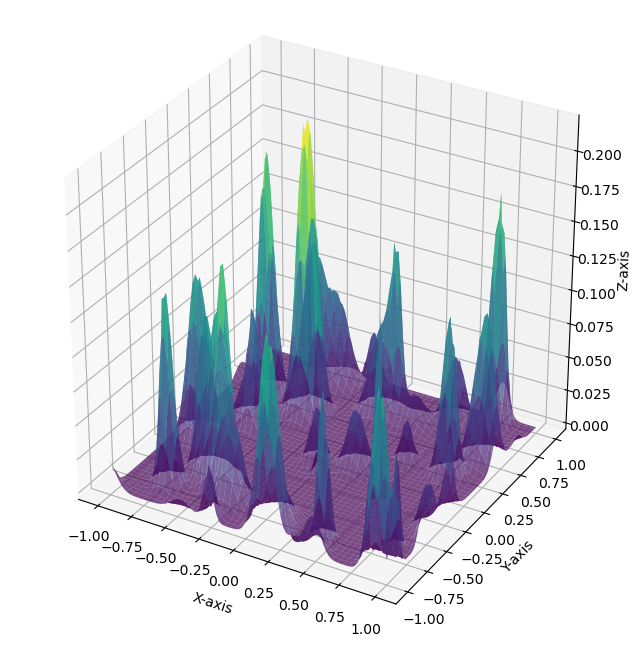

In [34]:
#Plot the bump surface as in the material function
keyword = "NormalNewGeom"
path = "../json/surfaceParams" + keyword + ".json"
def load_params(path = path):
    with open(path, "r") as f:
        return json.load(f)
params = load_params()

bumps = params["bumpData"]

def plot_bump_surface():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1, 1, 1])  # aspect ratio is 1:1:1

    # Create a grid of points
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)

    # Calculate the Z values based on the bumps
    Z = np.zeros_like(X)
    for b in bumps:
        dx = X - b["x0"]
        dy = Y - b["y0"]
        exponent = - (dx**2 + dy**2) / (2 * b["sigma"]**2)
        Z += b["height"] * np.exp(exponent)

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    # Set labels
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.show()
plot_bump_surface()


In [26]:
import pandas as pd

df_scatt = pd.DataFrame(flux_results)
df_inc = pd.DataFrame(inc_flux_results)

# Save both to CSV
df_scatt.to_csv("filesCSV/scattered_flux_results.csv", index=False)
df_inc.to_csv("filesCSV/incident_flux_results.csv", index=False)

# Confirm structure
print(df_scatt.head())


   frequency  beta direction          flux       type
0   6.516667   0.0        X1 -8.578172e-23  scattered
1   6.566667   0.0        X1 -8.297493e-23  scattered
2   6.616667   0.0        X1 -8.028144e-23  scattered
3   6.666667   0.0        X1 -7.769462e-23  scattered
4   6.716667   0.0        X1 -7.520832e-23  scattered


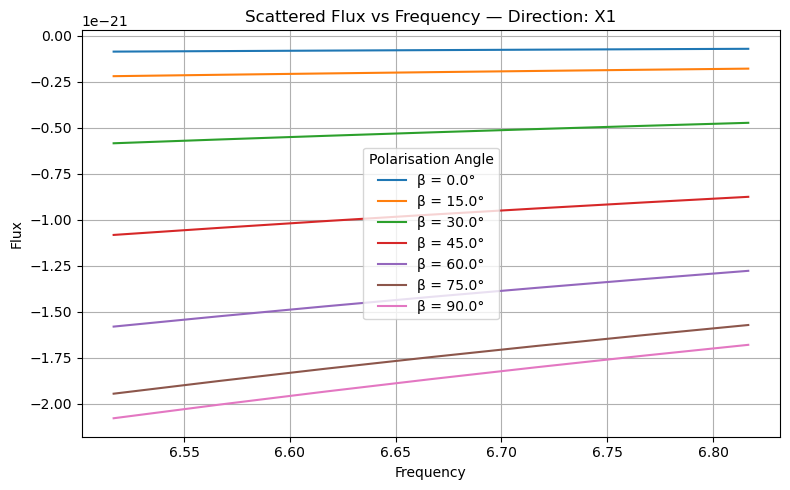

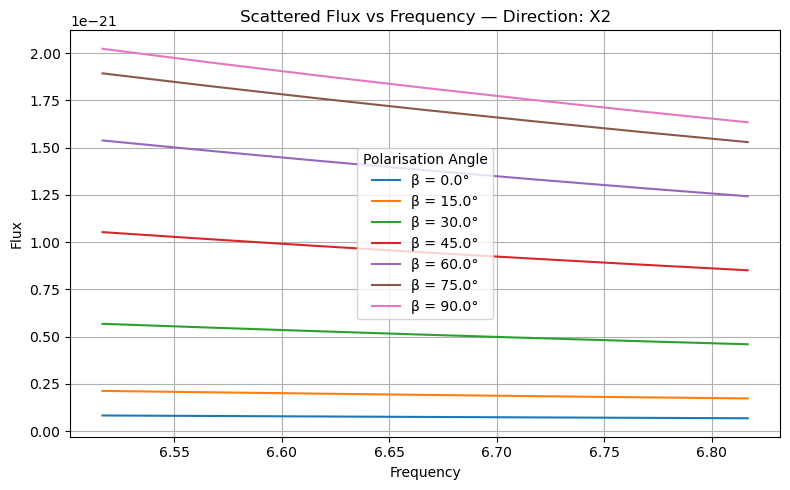

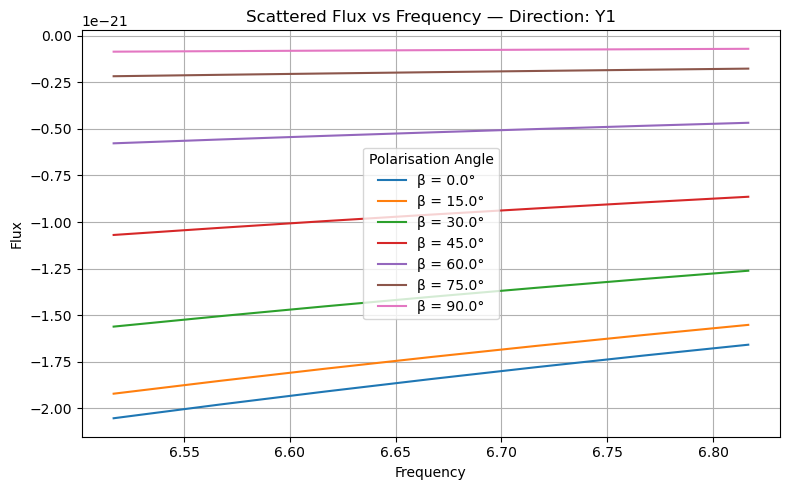

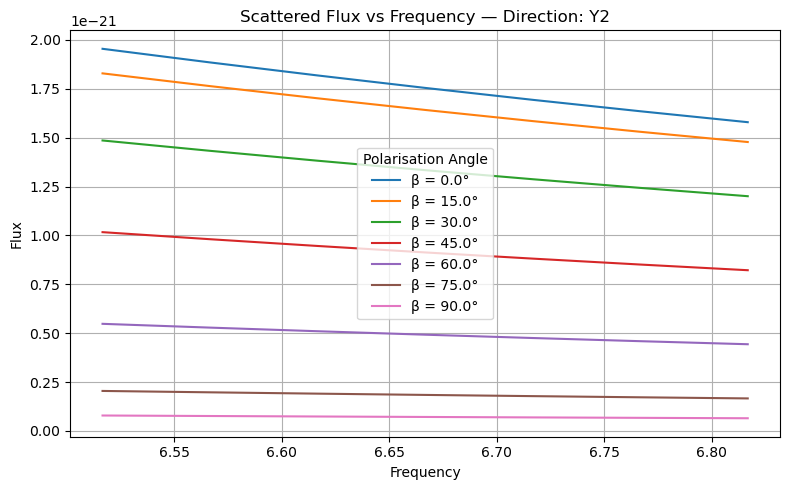

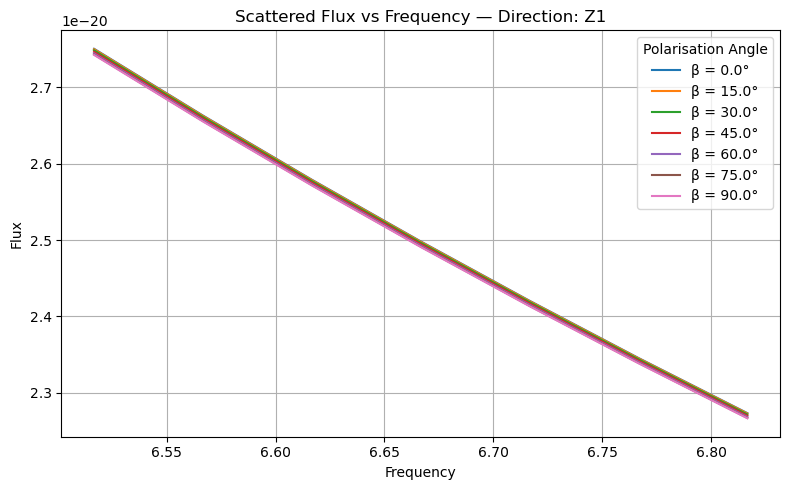

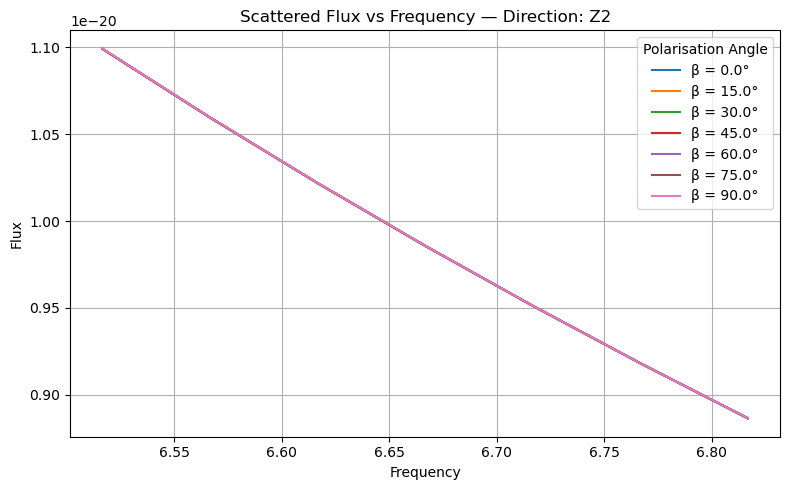

In [27]:
import matplotlib.pyplot as plt

directions = sorted(df_scatt["direction"].unique())
betas = sorted(df_scatt["beta"].unique())

for direction in directions:
    plt.figure(figsize=(8, 5))
    for beta in betas:
        sub = df_scatt[(df_scatt["direction"] == direction) & (df_scatt["beta"] == beta)]
        plt.plot(sub["frequency"], sub["flux"], label=f"β = {beta:.1f}°")

    plt.title(f"Scattered Flux vs Frequency — Direction: {direction}")
    plt.xlabel("Frequency")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Polarisation Angle")
    plt.tight_layout()
    plt.show()


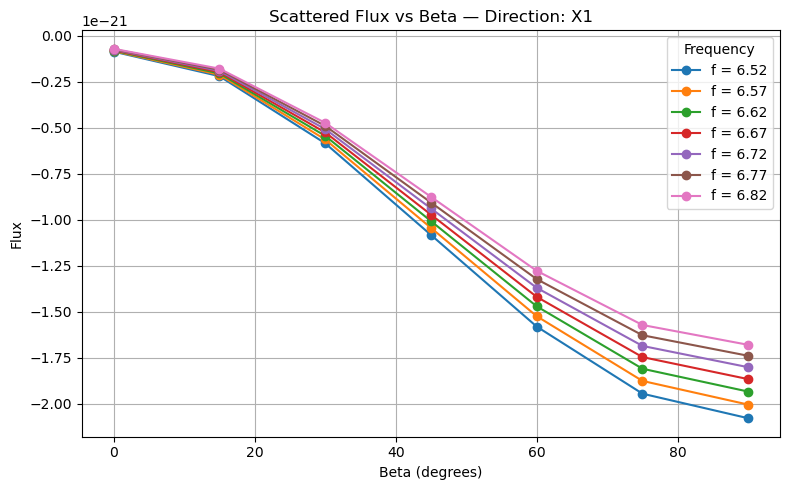

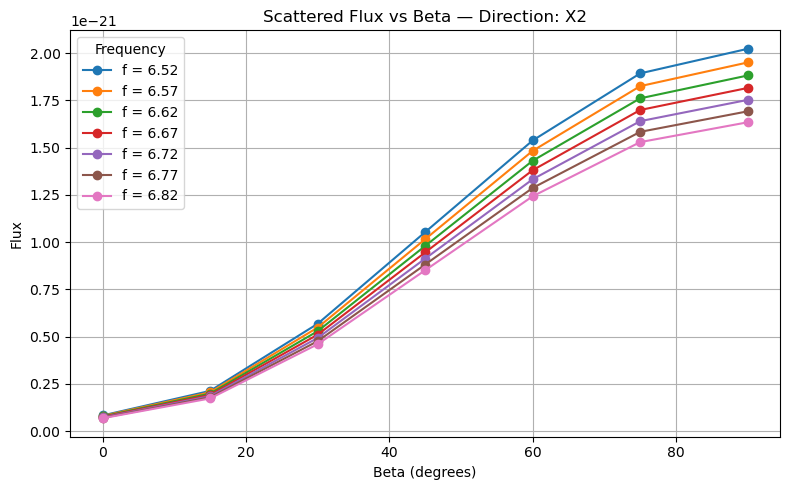

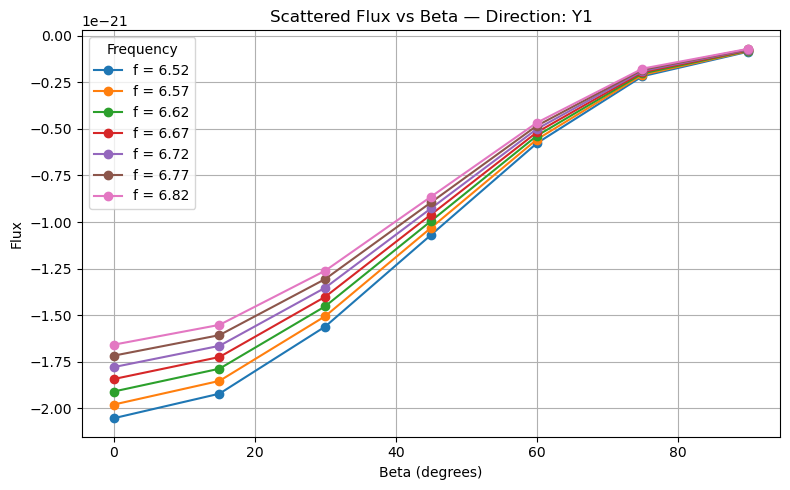

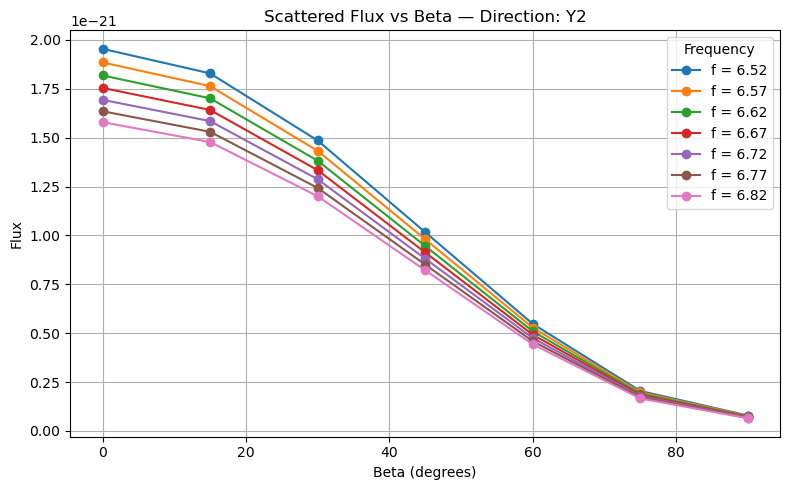

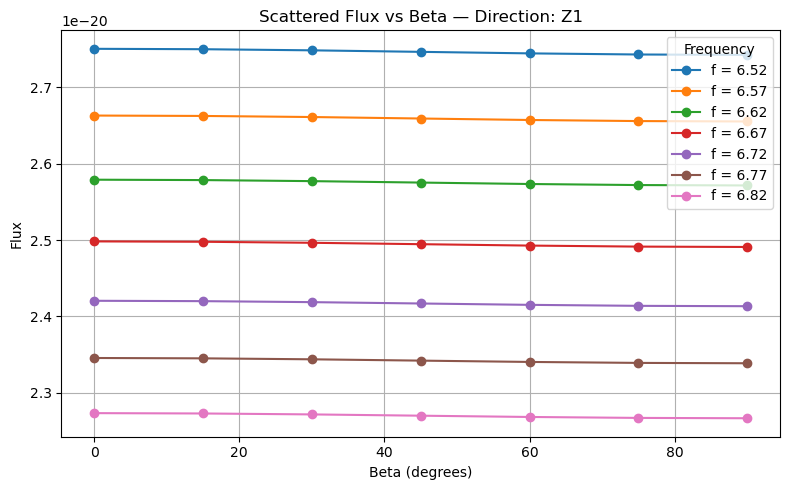

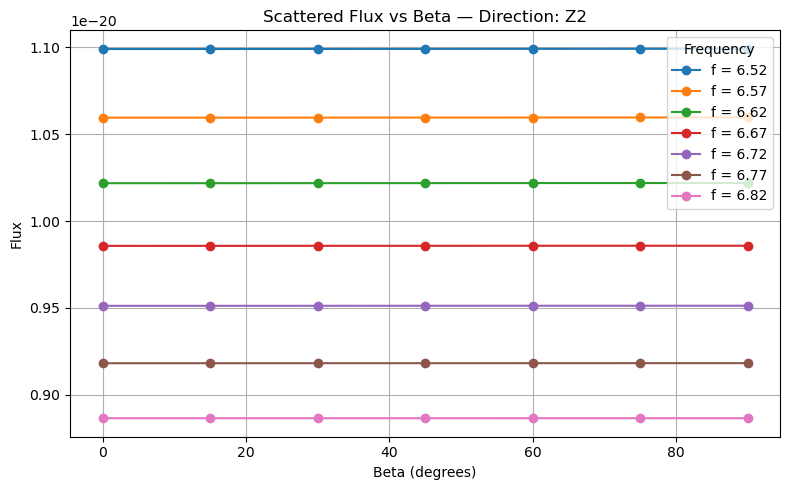

In [28]:
import matplotlib.pyplot as plt
import numpy as np

directions = sorted(df_scatt["direction"].unique())
frequencies = sorted(df_scatt["frequency"].unique())

for direction in directions:
    plt.figure(figsize=(8, 5))
    for f in frequencies:
        sub = df_scatt[(df_scatt["direction"] == direction) & (np.isclose(df_scatt["frequency"], f, atol=1e-5))]
        plt.plot(sub["beta"], sub["flux"], marker='o', label=f"f = {f:.2f}")

    plt.title(f"Scattered Flux vs Beta — Direction: {direction}")
    plt.xlabel("Beta (degrees)")
    plt.ylabel("Flux")
    plt.grid(True)
    plt.legend(title="Frequency")
    plt.tight_layout()
    plt.show()


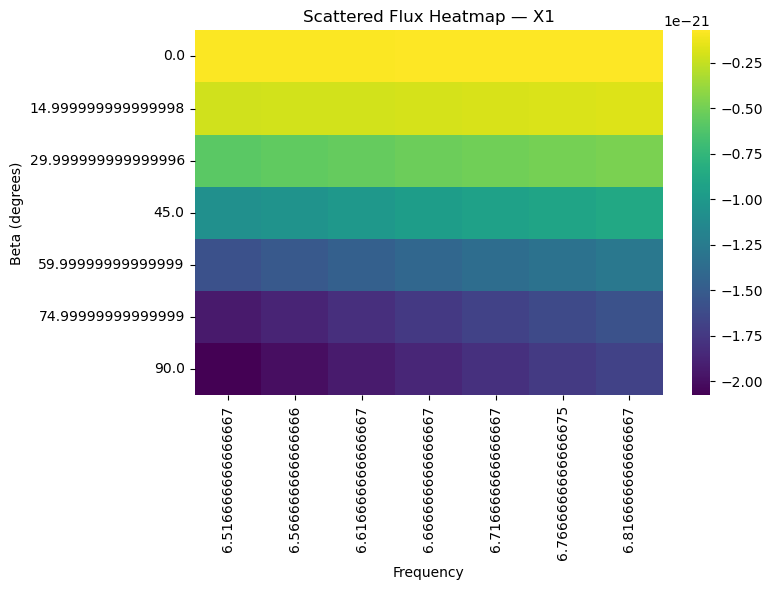

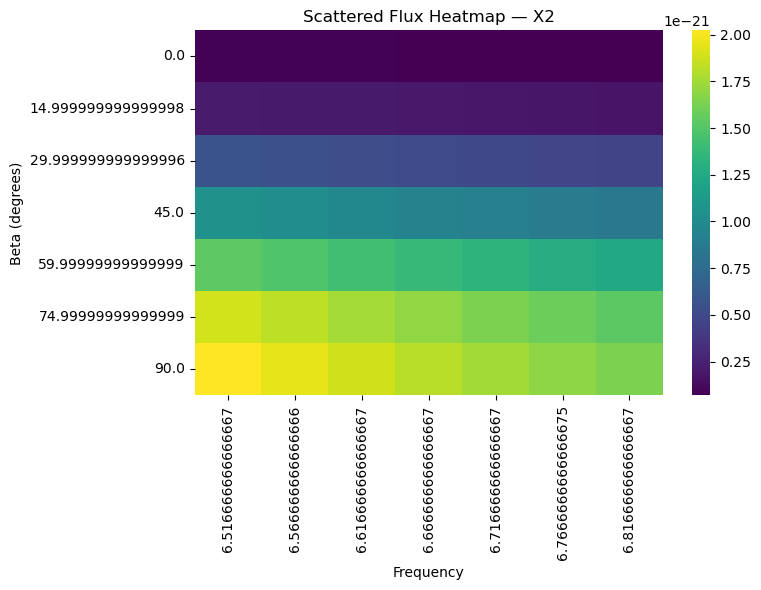

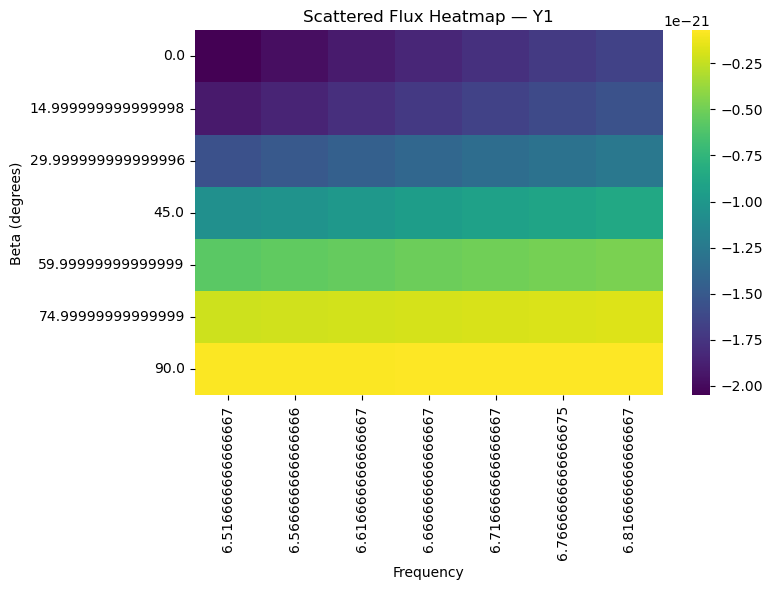

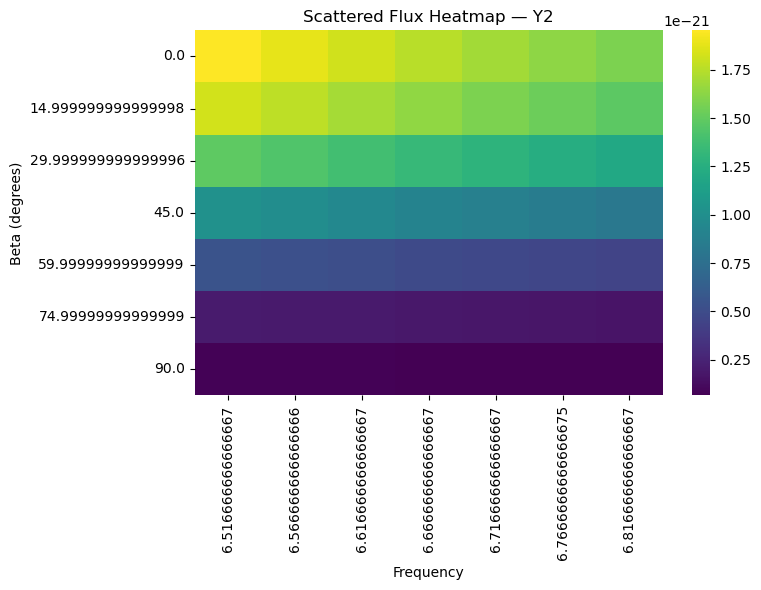

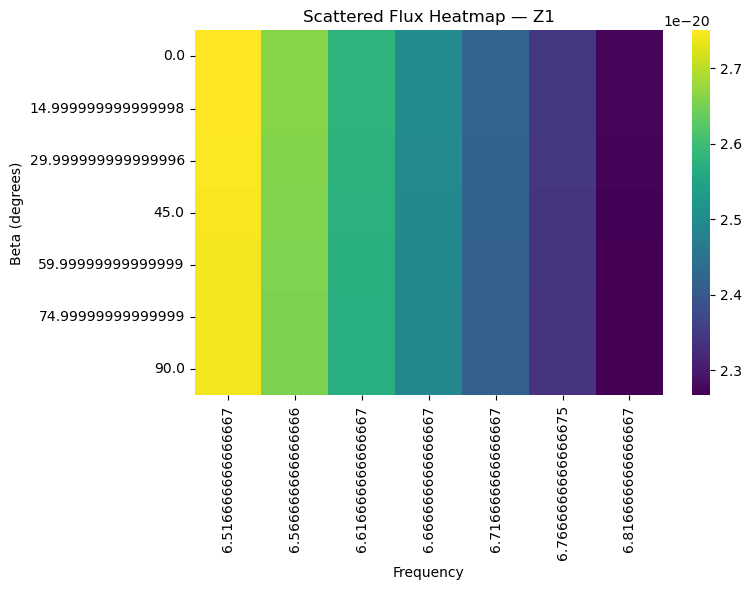

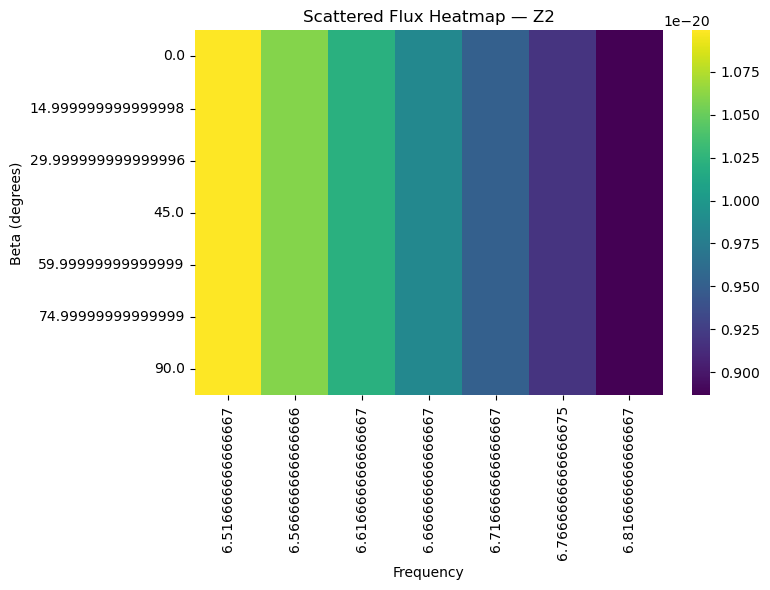

In [29]:
import seaborn as sns
for direction in directions:
    df_pivot = df_scatt[df_scatt["direction"] == direction].pivot(index="beta", columns="frequency", values="flux")
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_pivot, cmap="viridis")
    plt.title(f"Scattered Flux Heatmap — {direction}")
    plt.xlabel("Frequency")
    plt.ylabel("Beta (degrees)")
    plt.tight_layout()
    plt.show()


In [30]:
d = flux_1
#d = flux_1
print("Size of dict:", len(d))
d

Size of dict: 6


{'X1': array([-8.57817158e-23, -8.29749283e-23, -8.02814366e-23, -7.76946173e-23,
        -7.52083188e-23, -7.28168213e-23, -7.05148001e-23]),
 'X2': array([8.29226458e-23, 8.02108059e-23, 7.76083613e-23, 7.51089189e-23,
        7.27065406e-23, 7.03957053e-23, 6.81712729e-23]),
 'Y1': array([-2.05267393e-21, -1.97942246e-21, -1.90942370e-21, -1.84247822e-21,
        -1.77840131e-21, -1.71702171e-21, -1.65818045e-21]),
 'Y2': array([1.95449162e-21, 1.88481043e-21, 1.81822046e-21, 1.75453226e-21,
        1.69357038e-21, 1.63517210e-21, 1.57918641e-21]),
 'Z1': array([2.75050304e-20, 2.66310428e-20, 2.57910673e-20, 2.49831554e-20,
        2.42054955e-20, 2.34564006e-20, 2.27342987e-20]),
 'Z2': array([1.09904650e-20, 1.05953271e-20, 1.02178642e-20, 9.85698899e-21,
        9.51169486e-21, 9.18104844e-21, 8.86418351e-21])}

In [31]:
d = inc_flux_1
print("Size of dict:", len(d))
d




Size of dict: 6


{'X1': array([5.78551458e-33, 5.04249698e-33, 4.81686412e-34, 6.38059885e-34,
        9.45401471e-34, 3.72121182e-34, 2.58128678e-34]),
 'X2': array([ 1.61478385e-32,  9.35218754e-33, -1.63402002e-33, -1.11325029e-34,
        -1.05644625e-33,  2.34193460e-34,  4.37452062e-34]),
 'Y1': array([-2.38888013e-33,  7.92649018e-33, -1.28286589e-33,  2.26742063e-33,
         2.04628413e-33,  2.11112303e-33,  2.05812426e-33]),
 'Y2': array([ 1.04217540e-32, -1.96157867e-33, -9.80714595e-33, -8.56404053e-33,
        -8.77848431e-33, -9.91841501e-33, -9.71496376e-33]),
 'Z1': array([3.53375769e-21, 3.41728733e-21, 3.30555882e-21, 3.19829374e-21,
        3.09523355e-21, 2.99613792e-21, 2.90078319e-21]),
 'Z2': array([ 1.48372221e-21, -1.18488066e-21, -2.90530796e-21,  1.38926367e-20,
         1.14220490e-20,  1.98893034e-21,  1.21554873e-21])}